# Chronos Bolt on MUSED-FM using run_musedfm Functions

This notebook demonstrates how to run Chronos Bolt on the MUSED-FM benchmark using the functions from `run_musedfm.py`. This simplifies the outputs to make easier 

In [ ]:
import os
import pandas as pd
import numpy as np
import torch
from pathlib import Path
from typing import Optional

# Import MUSED-FM components
from musedfm.data import Benchmark
from musedfm.metrics import MAPE, MAE, RMSE, NMAE

# Import functions from the examples package
from examples import (
    run_models_on_benchmark, 
    compare_model_performance, 
    export_hierarchical_results_to_csv
)

print("MUSED-FM components imported successfully!")


MUSED-FM components imported successfully!


In [69]:
# Self-contained ChronosForecast class for the notebook (FIXED VERSION)
class ChronosForecast:
    """
    Chronos forecasting model wrapper for MUSED-FM evaluation.
    This class is self-contained within the notebook.
    """
    
    def __init__(self, model_path: str = "amazon/chronos-bolt-base", device: str = "cuda:0", num_samples: int = 20):
        """
        Initialize Chronos forecast model.
        
        Args:
            model_path: Path to Chronos model (HuggingFace model ID or local path)
            device: Device to run the model on
            num_samples: Number of samples for probabilistic forecasting
        """
        self.model_path = model_path
        self.device = device
        self.num_samples = num_samples
        self.pipeline = None
        self._load_model()
    
    def _load_model(self):
        """Load the Chronos model."""
        try:
            from chronos import BaseChronosPipeline, ForecastType
            
            self.pipeline = BaseChronosPipeline.from_pretrained(
                self.model_path,
                device_map=self.device,
            )
            print(f"Loaded Chronos model: {self.model_path}")
        except ImportError:
            raise ImportError("Chronos package not installed. Please install with: pip install chronos-forecasting")
        except Exception as e:
            raise RuntimeError(f"Failed to load Chronos model: {e}")
    
    def forecast(self, history: np.ndarray, covariates: Optional[np.ndarray] = None, forecast_horizon: Optional[int] = None) -> np.ndarray:
        """
        Generate forecast from historical data using Chronos.
        
        Args:
            history: Historical time series data
            covariates: Optional covariate data (ignored for Chronos)
            forecast_horizon: Number of future points to forecast (default: 1)
            
        Returns:
            Forecast values
        """
        if forecast_horizon is None:
            forecast_horizon = 1
        
        # normalize using history prior to forecasting
        history_mean = np.mean(history)
        history_std = np.std(history)
        history = (history - history_mean) / max(history_std, 1e-10)
        
        # Convert history to torch tensor
        if isinstance(history, np.ndarray):
            history_tensor = torch.tensor(history, dtype=torch.float32)
        else:
            history_tensor = torch.tensor(np.array(history), dtype=torch.float32)
        
        # Remove NaN values
        history_clean = history_tensor[~torch.isnan(history_tensor)]
        
        if len(history_clean) == 0:
            # If no valid data, return zeros
            return np.zeros(forecast_horizon)
        
        # Ensure we have enough history for forecasting
        if len(history_clean) < 2:
            # If insufficient data, return the last value repeated
            last_value = float(history_clean[-1]) if len(history_clean) > 0 else 0.0
            return np.full(forecast_horizon, last_value)
        
        # Generate forecast using Chronos
        # Use predict method instead of predict_quantiles
        context = [history_clean]                                                                                       
        
        # Determine prediction kwargs based on forecast type
        predict_kwargs = {}
        if hasattr(self.pipeline, 'forecast_type'):
            from chronos import ForecastType
            if self.pipeline.forecast_type == ForecastType.SAMPLES:
                predict_kwargs = {"num_samples": self.num_samples}
        
        # Generate forecast
        forecast_output = self.pipeline.predict(
            context,
            prediction_length=forecast_horizon,
            **predict_kwargs
        )
        
        # Convert to numpy array
        if isinstance(forecast_output, torch.Tensor):
            forecast_np = forecast_output.detach().cpu().numpy()
        else:
            forecast_np = np.array(forecast_output)
        
        # Handle different output shapes
        if forecast_np.ndim > 1:
            # Chronos Bolt returns (batch_size, num_quantiles, prediction_length)
            # We want the median (0.5 quantile) which is typically at index 4 (0.1, 0.2, ..., 0.9)
            if forecast_np.ndim == 3 and forecast_np.shape[1] == 9:  # Standard Chronos Bolt quantiles
                # Take the median (0.5 quantile) at index 4
                forecast_np = forecast_np[0, 4, :]  # (batch_size=1, quantile=4, prediction_length)
            elif forecast_np.shape[0] > 1:
                # If we have multiple samples, take the mean
                forecast_np = np.mean(forecast_np, axis=0)
            else:
                forecast_np = forecast_np[0]
        
        # Ensure we have the right length
        if len(forecast_np) != forecast_horizon:
            if len(forecast_np) > forecast_horizon:
                forecast_np = forecast_np[:forecast_horizon]
            else:
                # Pad with the last value if needed - use concatenation to avoid broadcasting issues
                if len(forecast_np) > 0:
                    last_val = float(forecast_np[-1])
                    padding_length = forecast_horizon - len(forecast_np)
                    padding = np.full(padding_length, last_val)
                    forecast_np = np.concatenate([forecast_np, padding])
                else:
                    # If no valid forecast, fill with zeros
                    forecast_np = np.zeros(forecast_horizon)
        
        # denormalize using history prior to forecasting
        forecast_np = forecast_np * history_std + history_mean
        
        return forecast_np
            

print("ChronosForecast class defined successfully!")


ChronosForecast class defined successfully!


In [70]:
# Configuration
BENCHMARK_PATH = "/workspace/data/fm_eval_nested/"  # Adjust this path to your MUSED-FM data
MODEL_PATH = "amazon/chronos-bolt-base"  # Chronos Bolt model
DEVICE = "cuda:0"  # Use "cpu" if you don't have CUDA
NUM_SAMPLES = 20  # Number of samples for probabilistic forecasting
MAX_WINDOWS = 2  # Limit windows per dataset for faster testing
OUTPUT_DIR = "./results/chronos_bolt"

# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"Benchmark path: {BENCHMARK_PATH}")
print(f"Model: {MODEL_PATH}")
print(f"Device: {DEVICE}")
print(f"Output directory: {OUTPUT_DIR}")


Benchmark path: /workspace/data/fm_eval_nested/
Model: amazon/chronos-bolt-base
Device: cuda:0
Output directory: ./results/chronos_bolt


In [71]:
# Initialize Chronos model
try:
    chronos_model = ChronosForecast(
        model_path=MODEL_PATH,
        device=DEVICE,
        num_samples=NUM_SAMPLES
    )
    print("Chronos model initialized successfully!")
except Exception as e:
    print(f"Error initializing Chronos model: {e}")
    print("Make sure you have installed chronos-forecasting and have the required dependencies.")


Loaded Chronos model: amazon/chronos-bolt-base
Chronos model initialized successfully!


In [72]:
# Suppress Chronos prediction length warnings
import warnings
warnings.filterwarnings("ignore", 
                       message="We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it.",
                       category=UserWarning,
                       module="chronos")

# Suppress all Chronos warnings
warnings.filterwarnings("ignore", 
                       module="chronos")


In [ ]:
# Import plotting utilities
import matplotlib.pyplot as plt
from musedfm.plotting import plot_window_forecasts, plot_multiple_windows, plot_baseline_comparison

# Run Chronos evaluation with plot data collection (one window per dataset)
print("Starting Chronos evaluation with plot data collection...")

# Define models dictionary (same format as run_musedfm.py)
models = {
    "chronos": {"model": chronos_model, "univariate": True}
}

# Run evaluation using the efficient run_musedfm function with plot data collection
results = run_models_on_benchmark(
    benchmark_path=BENCHMARK_PATH,
    models=models,
    max_windows=MAX_WINDOWS,
    history_length=512,
    forecast_horizon=128,
    stride=256,
    load_cached_counts=True,
    collect_plot_data=True  # Enable plot data collection
)

print("Evaluation completed successfully!")

# Use plot data directly from results
if '_plot_data' in results:
    plot_data = results['_plot_data']
    print(f"\nUsing {len(plot_data)} windows directly from results for plotting")
    print("Plot data ready for visualization!")
else:
    print("No plot data collected during evaluation.")

Starting Chronos evaluation with plot data collection...
Running Multiple Models on Benchmark
Loading KITTI data from /workspace/data/fm_eval_nested/sequential/KITTI
Found 6114 parquet files
Successfully loaded 6114 valid files
Domain ALL_DATASETS not found in file hierarchy
successfully counted windows from cached JSON files
Domain ALL_DATASETS not found in file hierarchy
successfully counted windows from cached JSON files
Dataset aus_electricity not found in data_hierarchy.json
Loading ECL data from /workspace/data/fm_eval_nested/traditional/ecl
Found 1 parquet files
Successfully loaded 1 valid files
/workspace/data/fm_eval_nested/traditional/open_aq [PosixPath('/workspace/data/fm_eval_nested/traditional/open_aq/delhi_combined.parquet'), PosixPath('/workspace/data/fm_eval_nested/traditional/open_aq/reykjavik_combined.parquet'), PosixPath('/workspace/data/fm_eval_nested/traditional/open_aq/rotterdam_combined.parquet'), PosixPath('/workspace/data/fm_eval_nested/traditional/open_aq/winn

In [74]:
# Compare model performance
compare_model_performance(results)



Model Performance Comparison
Model                MAPE (%)   MAE        RMSE       NMAE       Time (s)  
--------------------------------------------------------------------------------
chronos              902.49     3710768.5360 4599404.3429 -0.4592    25.83     

Best Performance:
  Lowest MAPE: chronos (902.49%)
  Lowest MAE:  chronos (3710768.5360)
  Lowest RMSE: chronos (4599404.3429)
  Fastest:     chronos (25.83s)


Creating individual forecast plots...
Started Processing sequential/cifar100_timeseries_csvs - Window 0
Started Processing sequential/KITTI - Window 2
Plot saved to: results/chronos_bolt/plots/baseline_forecast_2.png


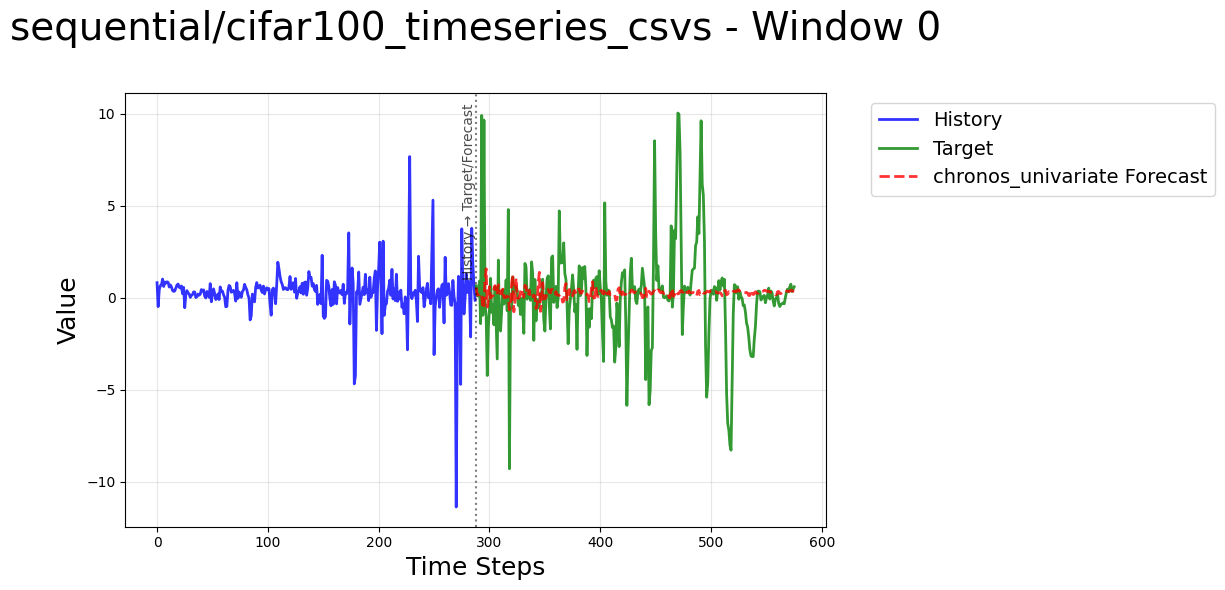

Saved plot 2: sequential/KITTI - Window 2
Started Processing sequential/ant_csv_out - Window 4
Plot saved to: results/chronos_bolt/plots/baseline_forecast_4.png


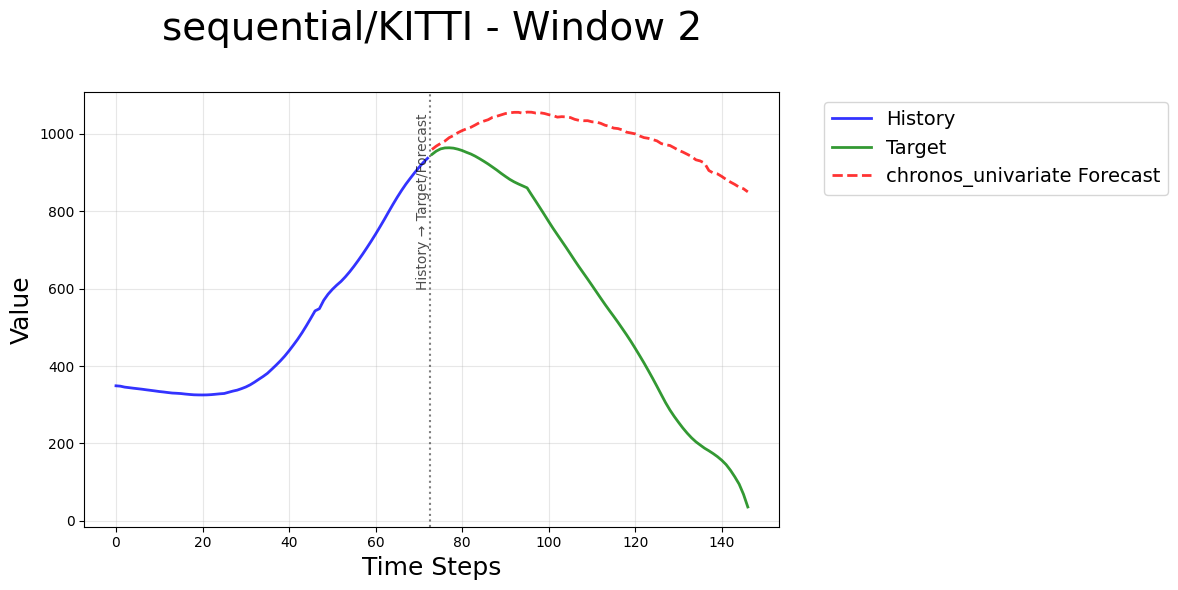

Saved plot 3: sequential/ant_csv_out - Window 4
Started Processing sequential/hopper_csv_out - Window 6
Plot saved to: results/chronos_bolt/plots/baseline_forecast_6.png


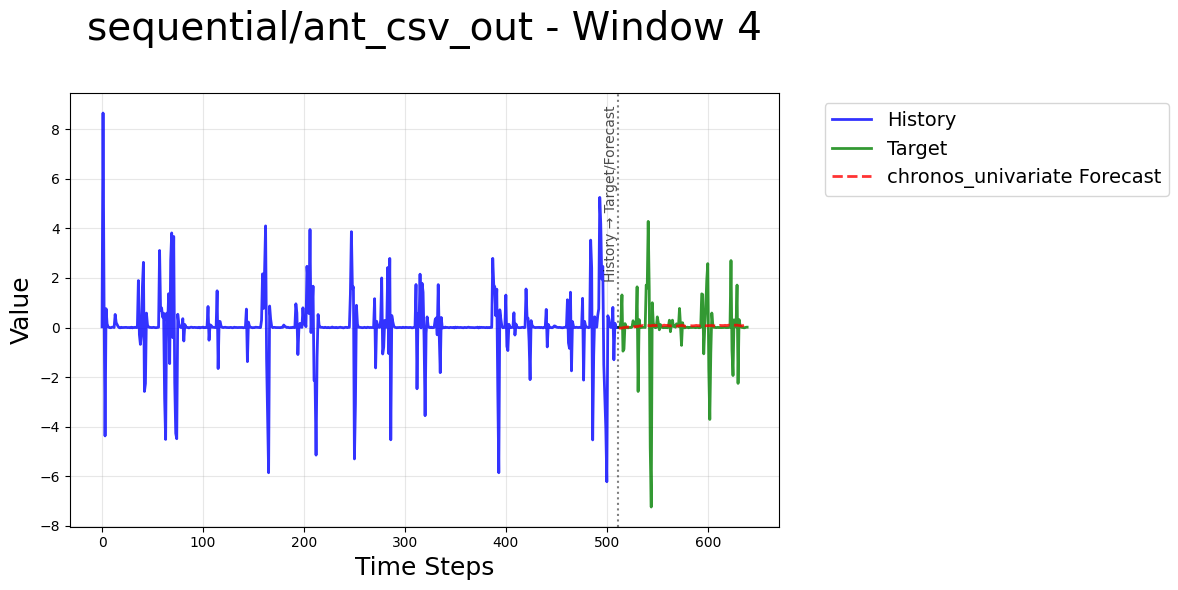

Saved plot 4: sequential/hopper_csv_out - Window 6
Started Processing sequential/spriteworld - Window 8
Plot saved to: results/chronos_bolt/plots/baseline_forecast_8.png


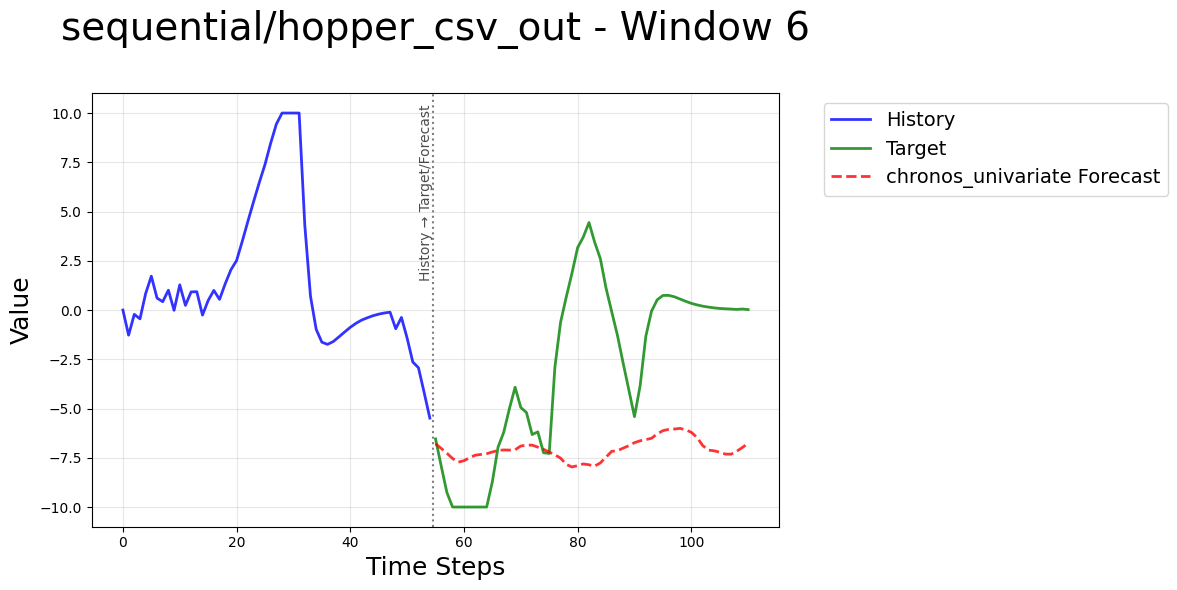

Saved plot 5: sequential/spriteworld - Window 8
Started Processing sequential/walker2d_csv_out - Window 10
Plot saved to: results/chronos_bolt/plots/baseline_forecast_10.png


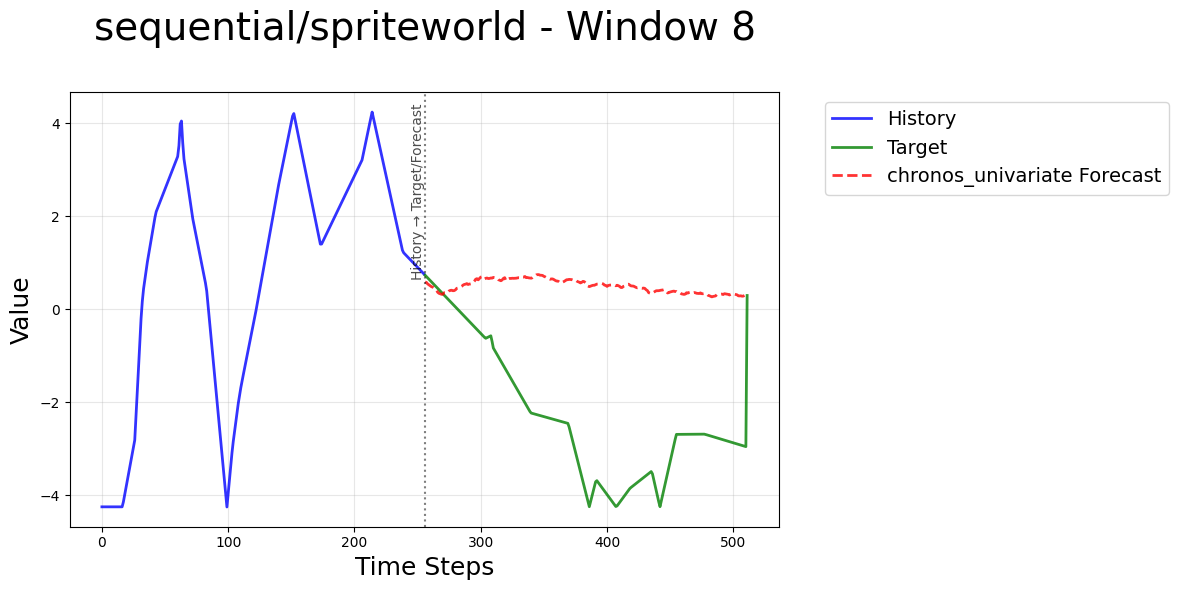

Saved plot 6: sequential/walker2d_csv_out - Window 10
Started Processing sequential/cheetah_csv_out - Window 12
Plot saved to: results/chronos_bolt/plots/baseline_forecast_12.png


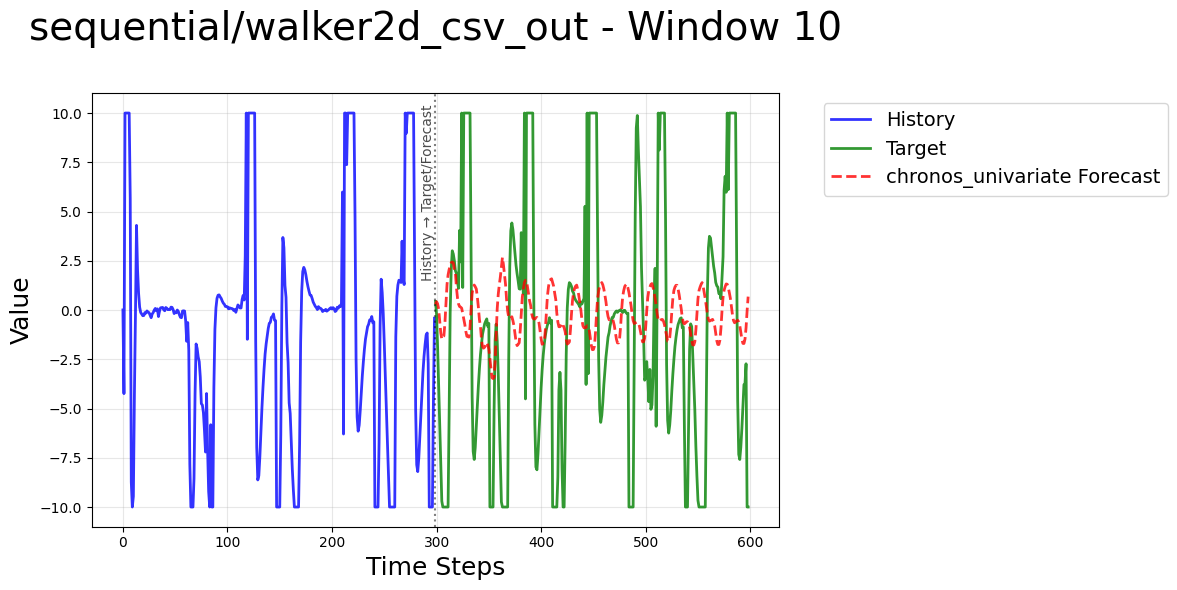

Saved plot 7: sequential/cheetah_csv_out - Window 12
Started Processing sequential/openwebtext_timeseries_csvs - Window 14
Plot saved to: results/chronos_bolt/plots/baseline_forecast_14.png


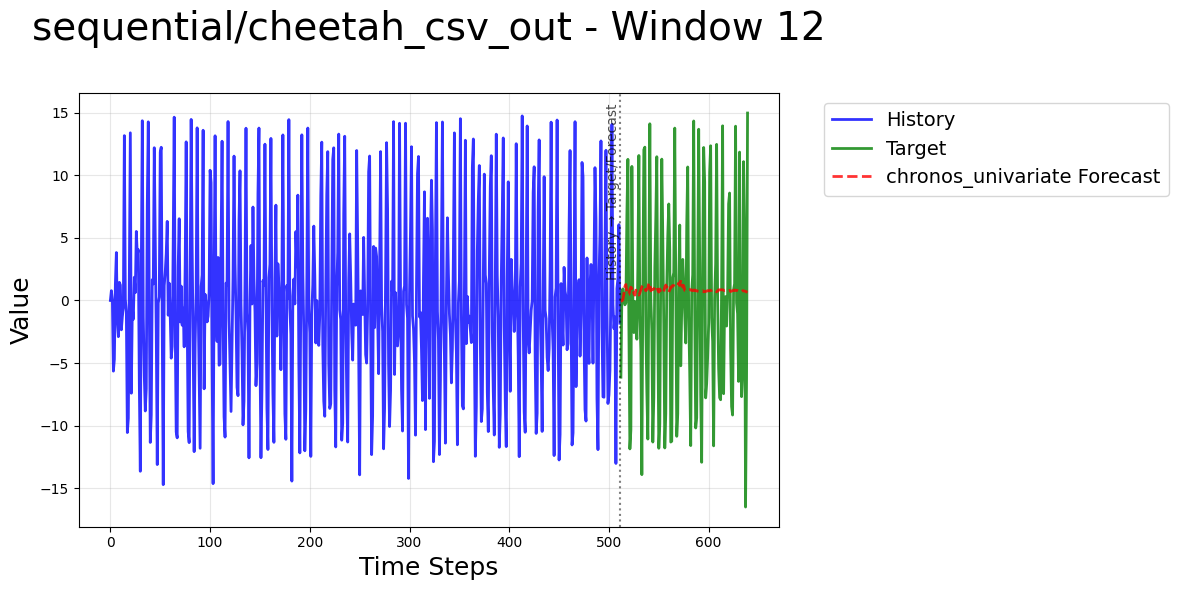

Saved plot 8: sequential/openwebtext_timeseries_csvs - Window 14
Started Processing synthetic/synthetic_scm/large_convlag_synin_s - Window 16
Plot saved to: results/chronos_bolt/plots/baseline_forecast_16.png


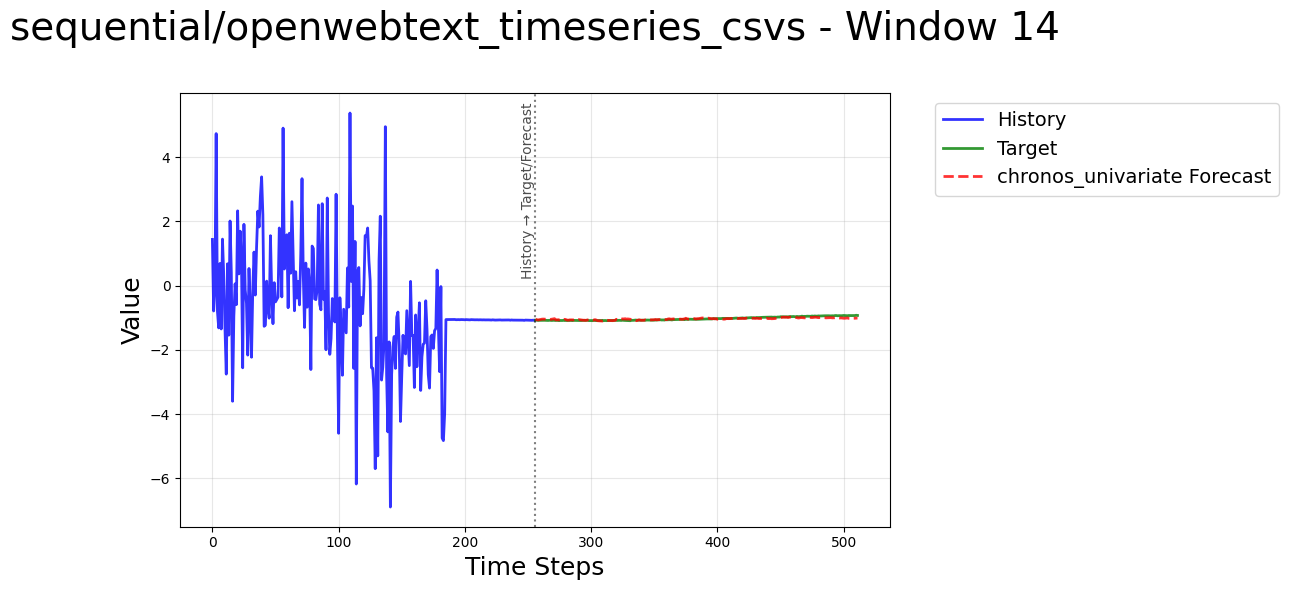

Saved plot 9: synthetic/synthetic_scm/large_convlag_synin_s - Window 16
Started Processing synthetic/synthetic_scm/medium_convlag_synin_s - Window 18
Plot saved to: results/chronos_bolt/plots/baseline_forecast_18.png


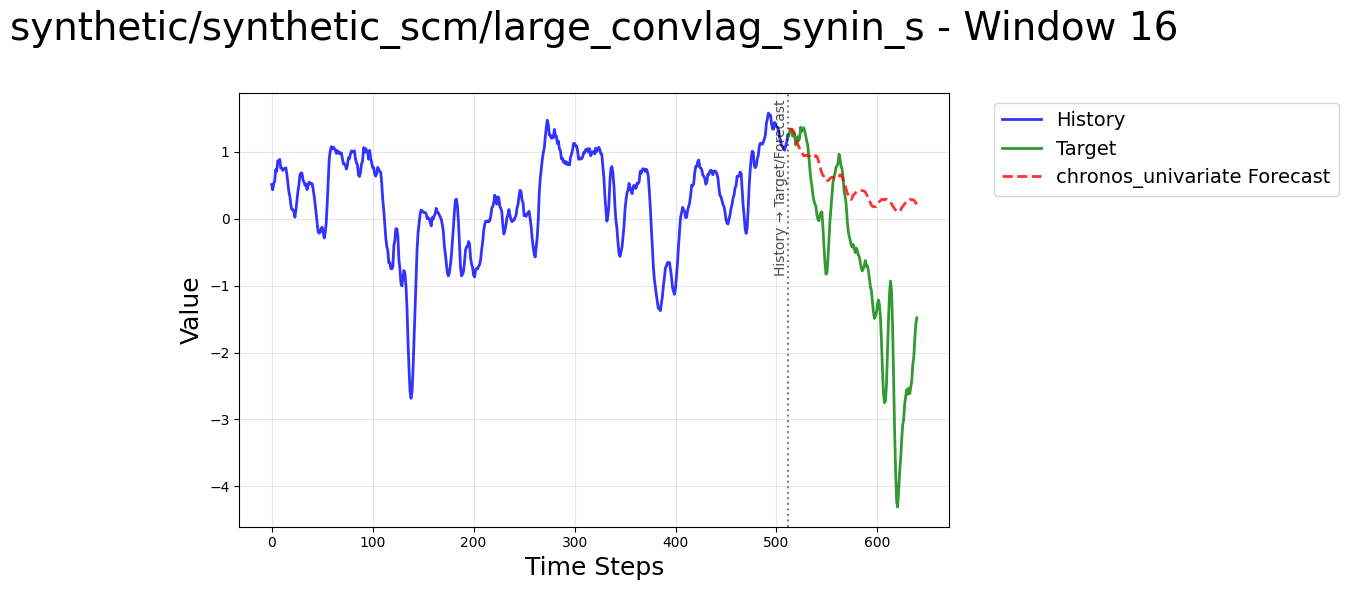

Saved plot 10: synthetic/synthetic_scm/medium_convlag_synin_s - Window 18

Individual plots saved to: ./results/chronos_bolt/plots


In [75]:
import copy
# Create individual plots for each window
if plot_data:
    print("Creating individual forecast plots...")
    
    # Create plots directory
    plots_dir = os.path.join(OUTPUT_DIR, "plots")
    os.makedirs(plots_dir, exist_ok=True)
    
    current_dataset_window_forecasts = ("", -1, {})
    last_window = None
    for i, data in enumerate(plot_data[:10]):  # Plot first 6 windows
        window = data['window']
        forecast = data['forecast']
        univariate_forecast = data['univariate_forecast']
        dataset_name = data['dataset_name']
        window_index = data['window_index']
        model_name = data['model_name']
        to_plot = False
        if current_dataset_window_forecasts[0] != dataset_name or current_dataset_window_forecasts[1] != window_index:
            to_plot = current_dataset_window_forecasts[0] != ""
            last_dataset_window_forecasts = copy.deepcopy(current_dataset_window_forecasts)
            current_dataset_window_forecasts = (dataset_name, window_index, {})
            print(f"Started Processing {dataset_name} - Window {window_index}")
        if forecast is not None:
            current_dataset_window_forecasts[2][model_name] = forecast
        if univariate_forecast is not None:
            current_dataset_window_forecasts[2][f"{model_name}_univariate"] = univariate_forecast
        if to_plot:
            # Create title
            forecasts = last_dataset_window_forecasts[2]
            title = f"{last_dataset_window_forecasts[0]} - Window {last_dataset_window_forecasts[1]}\n"
            
            # Plot the window
            plt = plot_window_forecasts(
                window=last_window,
                forecasts=forecasts,
                title=title,
                figsize=(12, 6),
                save_path=os.path.join(plots_dir, f"baseline_forecast_{window_index}.png"),
                show_plot=True
            )
            
            print(f"Saved plot {i+1}: {dataset_name} - Window {window_index}")
        last_window = window
    
    print(f"\nIndividual plots saved to: {plots_dir}")
    
else:
    print("No plot data available.")


In [76]:
# Export hierarchical results to CSV
export_hierarchical_results_to_csv(results, output_dir=OUTPUT_DIR)



Exporting Hierarchical Results to CSV
✓ Cleaned directory: ./results/chronos_bolt/categories
✓ Cleaned directory: ./results/chronos_bolt/domains
✓ Cleaned directory: ./results/chronos_bolt/datasets
✓ Category results saved: chronos_category_results.csv
✓ Dataset results saved: chronos_dataset_results.csv

Hierarchical CSV files saved to:
  Categories: ./results/chronos_bolt/categories/
  Domains: ./results/chronos_bolt/domains/
  Datasets: ./results/chronos_bolt/datasets/


In [77]:
# Export hierarchical results to CSV using the results from the previous evaluation
export_hierarchical_results_to_csv(results, output_dir=OUTPUT_DIR)



Exporting Hierarchical Results to CSV
✓ Cleaned directory: ./results/chronos_bolt/categories
✓ Cleaned directory: ./results/chronos_bolt/domains
✓ Cleaned directory: ./results/chronos_bolt/datasets
✓ Category results saved: chronos_category_results.csv
✓ Dataset results saved: chronos_dataset_results.csv

Hierarchical CSV files saved to:
  Categories: ./results/chronos_bolt/categories/
  Domains: ./results/chronos_bolt/domains/
  Datasets: ./results/chronos_bolt/datasets/


In [78]:
# Display results summary
if results and 'chronos' in results:
    chronos_results = results['chronos']
    print("\nChronos Results Summary:")
    print(f"Total windows processed: {chronos_results['windows']}")
    print(f"Total time: {chronos_results['time']:.2f} seconds")
    
    if chronos_results['metrics']:
        metrics = chronos_results['metrics']
        print(f"Average MAPE: {metrics.get('MAPE', 'N/A'):.2f}%")
        print(f"Average MAE: {metrics.get('MAE', 'N/A'):.4f}")
        print(f"Average RMSE: {metrics.get('RMSE', 'N/A'):.4f}")
        print(f"Average NMAE: {metrics.get('NMAE', 'N/A'):.4f}")
    
    print(f"\nResults saved to: {OUTPUT_DIR}")
else:
    print("No results available.")



Chronos Results Summary:
Total windows processed: 169
Total time: 25.83 seconds
Average MAPE: 902.49%
Average MAE: 3710768.5360
Average RMSE: 4599404.3429
Average NMAE: -0.4592

Results saved to: ./results/chronos_bolt


## Summary

This notebook demonstrates how to run Chronos Bolt on the MUSED-FM benchmark using the efficient functions from `run_musedfm.py`. 

### Key Benefits:

1. **Efficient**: Uses optimized evaluation functions instead of custom loops
2. **Self-contained**: ChronosForecast class defined within the notebook
3. **Comprehensive**: Generates hierarchical CSV results and performance comparisons
4. **Minimal code**: Only ~10 cells vs. hundreds of lines in custom evaluation

### Functions Used:

- `run_models_on_benchmark()`: Main evaluation function
- `compare_model_performance()`: Performance comparison
- `export_hierarchical_results_to_csv()`: Hierarchical CSV export

This approach leverages the existing, well-tested evaluation framework while keeping the notebook clean and efficient.
